In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import geopandas as gpd

from sqlalchemy import create_engine
import requests

from importlib import reload
import mta_functions
import pickle
import warnings
warnings.filterwarnings('ignore')

In [2]:
reload(mta_functions)
from mta_functions import *

In [3]:
con = create_engine('sqlite:///mta_data.db')
con.connect() 

### Get MTA station data

In [4]:
# load reference data combining station names, boroughs, train lines, geographical coordinates etc.
st = pd.read_csv('Stations.csv')

# reducing dataframe size and cleaning column names

st = clean_station_cols(st)    
st['ref_station_name'] = st['ref_station_name'].str.upper()

st.head()

,station_id,complex_id,gtfs_id,ref_station_name,borough,routes,lat,long
0,1,1,R01,ASTORIA-DITMARS BLVD,Q,N W,40.775036,-73.912034
1,2,2,R03,ASTORIA BLVD,Q,N W,40.770258,-73.917843
2,3,3,R04,30 AV,Q,N W,40.766779,-73.921479
3,4,4,R05,BROADWAY,Q,N W,40.761820,-73.925508
4,5,5,R06,36 AV,Q,N W,40.756804,-73.929575


In [5]:
# load station names in SQL database

st.to_sql('stations', con, if_exists='append', index=False)


In [6]:
# load map of reference station names to turnstile df station names

with open('station_dict.pickle', 'rb') as handle:
    station_dict = pickle.load(handle)

### Get NYC bike route data

In [7]:
# Source: https://data.cityofnewyork.us/Transportation/Bicycle-Routes/7vsa-caz7

city = gpd.read_file('./bike_routes/bike_routes.geojson')

In [8]:
# importing borough geometry for mapping
url = 'https://services5.arcgis.com/GfwWNkhOj9bNBqoJ/arcgis/rest/services/NYC_Borough_Boundary/FeatureServer/0/query?where=1=1&outFields=*&outSR=4326&f=pgeojson'
boro_geo = gpd.read_file(url)

### Get Citibike station data

The plot below shows current Citibike docking stations as of September 2021.

In [9]:
# Source: https://www.citibikenyc.com/system-data

citibike_spots = load_citibike_sites()

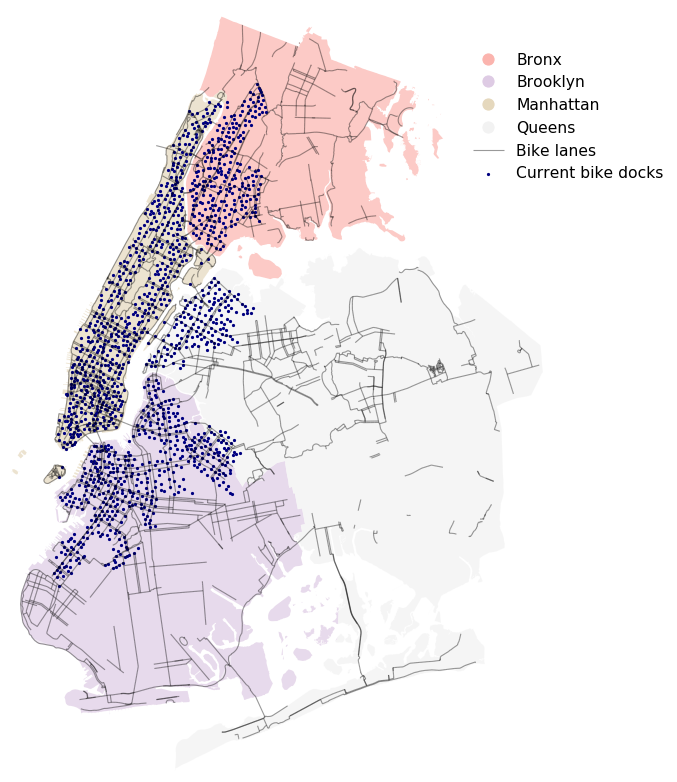

In [10]:
plt.rcParams.update({'font.size': 14})

# plot bike lanes and current dock locations
ax = map_nyc_citibike_docks(citibike_spots, color='navy')
h = ax.get_legend().legendHandles

# plot background borough map
boro_geo[boro_geo.BoroCode<5].plot(column='BoroName', ax=ax, cmap='Pastel1', alpha=0.7, 
                                   zorder=0, categorical=True, label=boro_geo.BoroName)

# creating custom legend handles
cmap = plt.cm.get_cmap('Pastel1')
patches = []
for i in range(4):
    patch = mlines.Line2D([], [], color=cmap(i*3), marker='o', markersize=10, linewidth=0)
    patches.append(patch)

ax.legend(handles=patches+h, 
          labels=['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Bike lanes', 'Current bike docks'],
          bbox_to_anchor=(0.75, 0.95), loc='upper left', borderaxespad=0, frameon=False)

plt.axis('off')
plt.tight_layout()
plt.savefig('citibike_docks_boro_map.png')

### Get MTA Turnstile data

In [11]:
# select rows during peak evening traffic, throughout May, June, and July 2019

ts = pd.read_sql("SELECT * FROM mta_data\
            WHERE DATE BETWEEN '05/01/2019' AND '07/31/2019' \
                AND TIME >= '15:00:00';", con=con)

In [12]:
ts = add_turnstile_cols(ts)

In order to focus on station traffic during evening rush hours, the data can be reduced to turnstile 
records between 3pm and 9pm. Within this range, most timestamps are at 8pm and count exits from 4pm-8pm

In [13]:
ts = ts[(ts.time_diff >= 3) & (ts.time_diff <= 5)]
ts = ts[(ts.time >= '20:00:00') & (ts.time <= '21:00:00')]

# Weekend counts will be taken out later on

### Merging station reference list with turnstile station data

The MTA publishes a reference list of all stations in the network, but stations in this list are labeled differently than in the turnstile dataset.

In order to geographically locate the busiest stations, I will format the station names to match and then join the two data sources.

In [14]:
# keep the original name for reference
st['station'] = st['ref_station_name'].copy()
st = format_station_names(st, 'station')

# keep the original name for reference
ts['ts_station_name'] = ts['station'].copy()
ts = format_station_names(ts, 'station')

ts_stations = ts[['ts_station_name', 'station', 'linename']].drop_duplicates()


In [15]:
# adjusting some of the remaining mismatched station names in the reference list

st['station'].replace(station_dict, inplace=True)

In [16]:
# assuming that a few stations listed under the same name (with different routes) are geographically 
# close together, & combining these rows

st = st.groupby('ref_station_name', as_index=False).agg({'station_id': 'first',
                                                          'gtfs_id': 'first',
                                                          'borough': 'first',
                                                          'routes': ''.join,
                                                          'station': 'first',
                                                          'lat': 'first',
                                                          'long': 'first'
                                                         })

In [17]:
# standardize route info for error checking

st['routes'] = st.routes.str.replace(' ', '').apply(lambda x: ''.join(sorted(list(x))))

ts_stations['linename'] = ts_stations.linename.apply(lambda x: ''.join(sorted(list(x))))
ts_stations.drop_duplicates(inplace=True)

In [18]:
# merge station data sources after adjustments

station_merge = st.merge(ts_stations, on='station', how='outer')

In [19]:
# dropping the unmatched stations, and keeping only the relevant boroughs
station_merge = station_merge[(~station_merge['borough'].isin(['M', 'SI']))].dropna()

In a few cases, the abbreviated station name matches multiple reference station names (e.g. "Newkirk" 
could refer to "Newkirk Av" or "Newkirk Plaza").

This can be resolved by looking at the route information and original names, and manually choosing the correct station ID for each turnstile station name, or combining stations that are part of one station complex. 

In [20]:
# demonstrating the overlapping station names
# station_merge[station_merge[['STATION', 'LINENAME']].duplicated(keep=False)].sort_values(['STATION', 'LINENAME'])

station_merge = clean_ts_station_duplicates(station_merge)

In [21]:
# the result - reference names & geo coordinates paired with turnstile station labels
station_ref = station_merge.copy()
station_ref.drop(['gtfs_id', 'ts_station_name', 'linename'], axis=1, inplace=True)
station_ref.head()

,ref_station_name,station_id,borough,routes,station,lat,long
0,103 ST-CORONA PLAZA,450.0,Q,7,103 ST CORONA,40.749865,-73.862700
1,104 ST,82.0,Q,AJZ,104 ST,40.695178,-73.844330
2,111 ST,81.0,Q,7AJ,111 ST,40.697418,-73.836345
3,121 ST,80.0,Q,JZ,121 ST,40.700492,-73.828294
4,138 ST-GRAND CONCOURSE,391.0,Bx,45,138 GRAND CONC,40.813224,-73.929849


### Filtering the station list -- removing sites with existing bike docks

In order to find the best sites for new bikeshare stations, we can exclude candidate locations that are already connected to the bikeshare system. 

In [22]:
# remove candidate station sites that are near existing bike docks

station_geo = gpd.GeoDataFrame(station_ref.reset_index(), 
                              geometry=gpd.points_from_xy(station_ref.long, station_ref.lat), 
                              crs="EPSG:4326")

overlap = []
for i in range(len(station_geo)):
    min_distance = citibike_spots.geometry.distance(station_geo['geometry'][i]).min()
    if min_distance < 0.003:
        overlap.append(station_geo.loc[i,'station_id'])
        
station_geo = station_geo.drop(station_geo[station_geo.station_id.isin(overlap)].index)
station_geo['marker_color'] = 'blue'


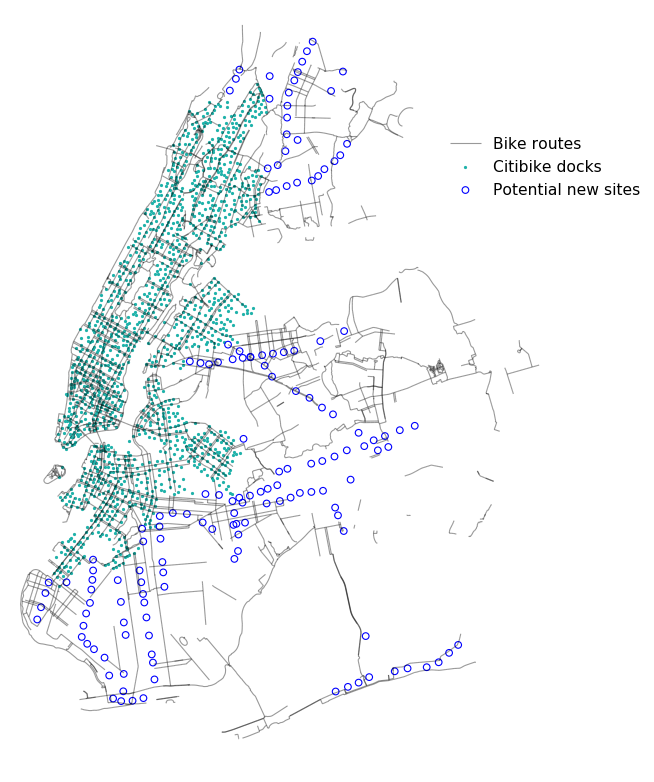

In [23]:
# mapping the remaining candidate station sites in relation to bike routes

ax = map_nyc_citibike_docks(citibike_spots)
map_nyc_stations(station_geo, ax=ax)
plt.axis('off')
plt.legend(['Bike routes', 'Citibike docks', 'Potential new sites'], 
           bbox_to_anchor=(0.8, 0.85), loc='upper left', frameon=False)
plt.tight_layout()
plt.savefig('citibike_docks_all_mta.png')

### Choose stations near bike paths

Next, I removed sites that are beyond 250m away from any bike lanes.

In [24]:
# querying bicycle routes API to find out if any bike paths are within a certain radius of each candidate site

distance = 250
headers = {"X-App-Token": 'Jo64YKvXJ0CvidAEr8pokXvfi'}
paths = []

for row in station_geo[['lat', 'long']].iterrows():
    lat = row[1].lat
    long = row[1].long
    parameters = {"$where": "within_circle(the_geom, %s, %s, %s)"%(lat, long, distance)}
    response = requests.get("https://data.cityofnewyork.us/resource/cc5c-sm6z.json", 
                            params=parameters, headers=headers)
    paths.append(len(response.json()))


In [25]:
# add a column with the number of bike paths that fall within a small radius for each station
station_geo['num_paths'] = paths
station_geo['marker_color'] = station_geo['num_paths'].apply(lambda x: 'red' if x == 0 else 'blue')

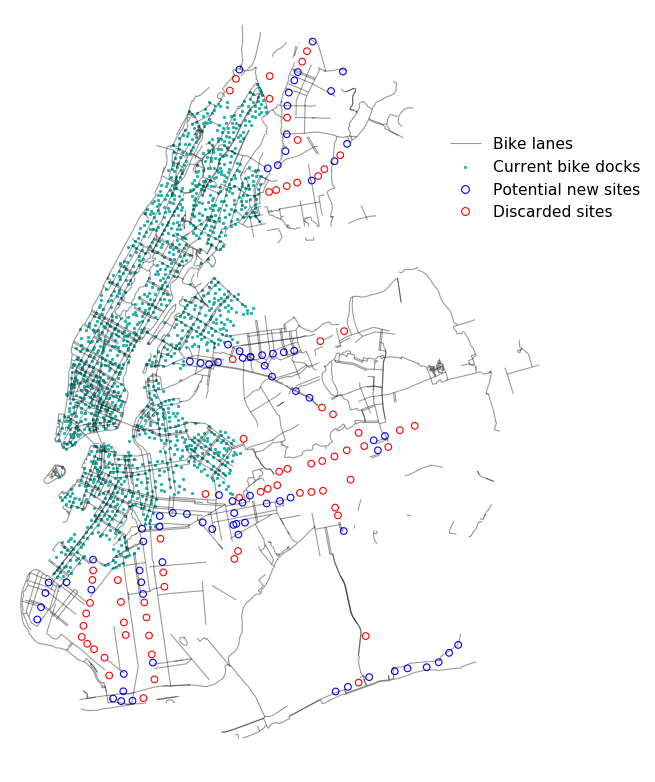

In [26]:
# map the stations with/without bike routes

ax = map_nyc_citibike_docks(citibike_spots)
h = ax.get_legend().legendHandles

map_nyc_stations(station_geo, ax=ax)

# creating custom legend handles
circles = []
for sites in zip(['b', 'r'], ['Potential new sites', 'Discarded sites']):
    circle = mlines.Line2D([], [], color=sites[0], marker='o', mfc='None', markersize=7, linewidth=0, label=sites[1])
    circles.append(circle)

ax.legend(handles=h+circles, 
          labels=['Bike lanes', 'Current bike docks', 'Potential new sites', 'Discarded sites'],
          bbox_to_anchor=(0.8, 0.85), loc='upper left', frameon=False)

plt.axis('off')
plt.tight_layout()
plt.savefig('stations_near_bike_routes.png')

In [27]:
# remove any stations with 0 nearby bike paths
station_geo = station_geo[station_geo['num_paths'] > 0]

### Merge cleaned & filtered station reference list with turnstile data

In [28]:
ts_cleaned = station_geo.merge(ts, on='station', how='left')

In [29]:
ts_cleaned.drop(['ts_station_name', 'linename'], axis=1, inplace=True)

### Clean negative and unlikely large counts

In [30]:
for col in ['exits_diff', 'entries_diff']:
    ts_cleaned[col] = ts_cleaned[col].apply(lambda x: np.abs(x))
    ts_cleaned = ts_cleaned[(ts_cleaned[col] < 10000)]

In [31]:
# account for Memorial Day (May 27) and July 4 holidays - remove May 27, July 4 and July 5

ts_cleaned = ts_cleaned[~ts_cleaned.date.isin(['05/27/2019', '07/04/2019', '07/05/2019'])]

Although most turnstiles were operating throughout the duration of the dataset (89 days in total), a few turnstiles
only sent data on less than 30 days - the only affected station (8 AV) could have noisier data,
so I will remove it from the analysis.

In [32]:
# faulty turnstiles
num_dates = ts_cleaned.groupby(['id', 'ref_station_name']).count()
num_dates[num_dates.station_id<30].index 

MultiIndex([('D002R390000002', '8 AV'),
            ('D002R390000302', '8 AV'),
            ('D002R390000303', '8 AV'),
            ('D002R390000600', '8 AV'),
            ('D002R390000601', '8 AV')],
           names=['id', 'ref_station_name'])

In [33]:
ts_cleaned = ts_cleaned[ts_cleaned['ref_station_name'] != '8 AV']

### Filling in missing data ("stuck" counters)

In [34]:
# when one turnstile fails to update, we can approximate the exits/entries using the median of 
# the other turnstiles in the same station

for col in ['exits_diff', 'entries_diff']:
    ts_cleaned.loc[ts_cleaned[col]==0, col] = np.nan
    ts_cleaned[col+'_fill'] = ts_cleaned.groupby(['station', 'datetime'])[col].transform(lambda x: x.fillna(x.median()))

    # if all turnstiles in a station failed to update, we can fill in values with the median for a given weekday
    ts_cleaned[col+'_fill'] = ts_cleaned.groupby(['id', 'weekday'])[col+'_fill'].transform(lambda x: x.fillna(x.median()))

ts_cleaned['foot_traffic'] = ts_cleaned['exits_diff_fill'] + ts_cleaned['entries_diff_fill']

### Indexing commuter-friendly stations

One measure of the volume of weekday 9-5 commuter traffic is to compare station traffic volume on weekdays vs. weekends.

In [35]:
# Adding a column for the ratio of station exits on any weekday vs. Sundays

station_wkdy_avg = ts_cleaned.groupby(['ref_station_name', 'datetime', 'weekday'], 
                                     as_index=False).sum().groupby(['ref_station_name', 'weekday'],
                                                                  as_index=False).mean()

station_wkdy_avg = station_wkdy_avg[['ref_station_name', 'weekday', 'entries_diff_fill', 'exits_diff_fill']]

station_wkdy_avg['weekday_ratio'] = station_wkdy_avg.groupby('ref_station_name')\
        .apply(lambda x: x / x[x['weekday']==6]['exits_diff_fill'].iloc[0])['exits_diff_fill']

Text(0.5, 0, '')

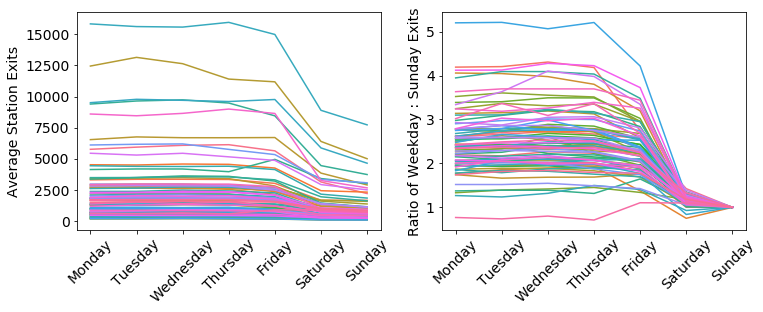

In [36]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
sns.lineplot(data=station_wkdy_avg, x='weekday', y='exits_diff_fill', hue='ref_station_name', legend=None)
plt.ylabel('Average Station Exits')
plt.xlabel(None)

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
ax.set_xticks(np.arange(7))
ax.set_xticklabels(weekdays, rotation=45)

ax = plt.subplot(122)
sns.lineplot(data=station_wkdy_avg, x='weekday', y='weekday_ratio', hue='ref_station_name', legend=None)
plt.ylabel('Ratio of Weekday : Sunday Exits')
ax.set_xticks(np.arange(7))
ax.set_xticklabels(weekdays, rotation=45)
plt.xlabel(None)


Some stations do seem to have more fluctuation throughout the week. There may be a greater market opportunity for bikeshare membership near to stations that reflect more commuter usage according to weeknight foot traffic.

In [37]:
# Setting up to filter by average weekday:weekend ratio per station

station_wkdy_avg = station_wkdy_avg[station_wkdy_avg.weekday < 5].groupby(['ref_station_name'], 
                         as_index=False).mean()[['ref_station_name', 'weekday_ratio']]

commuter_stations = station_wkdy_avg[station_wkdy_avg.weekday_ratio > 2]['ref_station_name'].to_list()


In [38]:
# Meanwhile, we can discard weekend data for the rest of the analysis

ts_cleaned = ts_cleaned[ts_cleaned.weekday < 5]

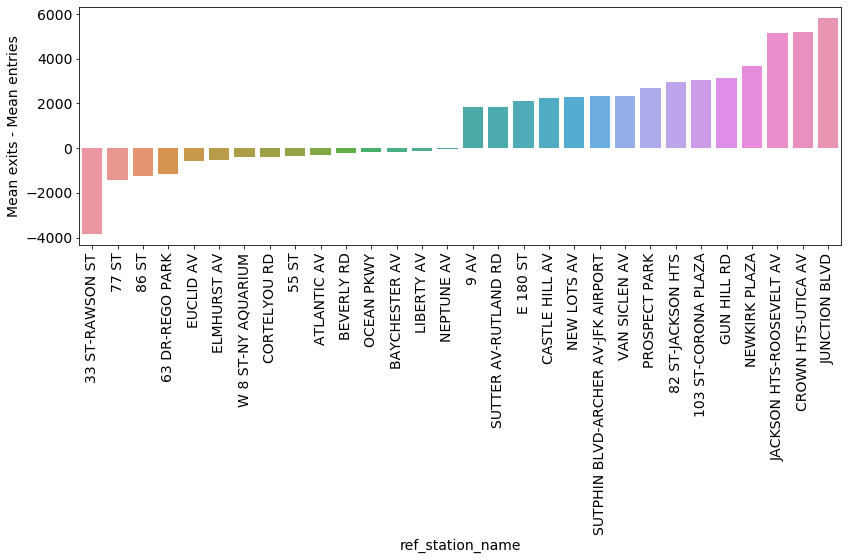

In [39]:
# A second measure - on weeknights, do more people exit or enter the station?


# sum over turnstiles for each evening
station_sum = ts_cleaned.groupby(['ref_station_name', 'date'], as_index=False).sum()

# avg station traffic per evening
station_avg = station_sum.groupby(['ref_station_name'], as_index=False).apply(lambda x: np.mean(x).astype(int))
station_avg = station_avg.merge(station_wkdy_avg, on='ref_station_name')

# stations with the most imbalance of commuter travel direction
plt.figure(figsize=(12,8))
station_avg['more_exits'] = (station_avg['exits_diff_fill'] - \
                             station_avg['entries_diff_fill'])
station_avg['pct_exits'] = (station_avg['exits_diff_fill'] / \
                             station_avg['entries_diff_fill'])

station_avg = station_avg.sort_values(by='more_exits')
sns.barplot(data=pd.concat([station_avg[:15], station_avg[-15:]]), x='ref_station_name', y='more_exits')
t = plt.xticks(rotation=90)
plt.tight_layout()
plt.ylabel('Mean exits - Mean entries')
plt.savefig('exits_entries_diff.png', bbox_inches='tight')

Generally, more commuters are exiting the busiest stations during peak hours, but one station shows many more people entering than exiting. These and other considerations could be useful later in the process of choosing the optimal bikeshare locations.

As seen below, there is a correlation between the ratio of weekday to weekend traffic, and the ratio of weeknight exits to entries.

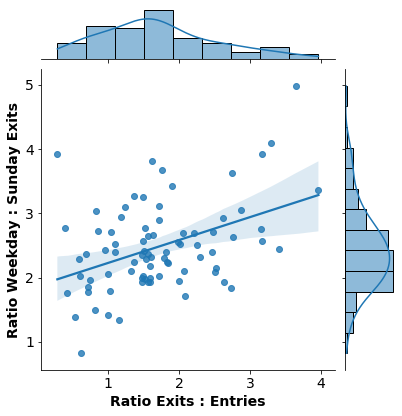

In [40]:
h = sns.jointplot(data=station_avg, x='pct_exits', y='weekday_ratio', kind='reg')

h.ax_joint.set_xlabel('Ratio Exits : Entries', fontweight='bold')
h.ax_joint.set_ylabel('Ratio Weekday : Sunday Exits', fontweight='bold')
plt.savefig('commuter_stations.png')

For now we can filter to select the "commuter-friendly" stations according to the weekday:weekend ratio. 

In [41]:
ts_cleaned = ts_cleaned[ts_cleaned.ref_station_name.isin(commuter_stations)]

### Which stations are busiest during evening peak hours?

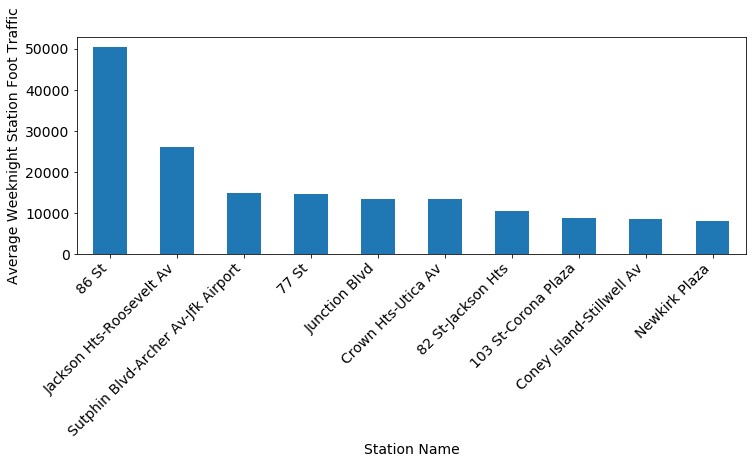

In [42]:
top_pm_stations = station_avg.sort_values(by='foot_traffic', ascending=False)[:40]

ax = top_pm_stations[:10].plot(kind='bar', legend=None, figsize=(12, 4), x='ref_station_name', y='foot_traffic')
plt.xlabel('Station Name')
plt.ylabel('Average Weeknight Station Foot Traffic')

labels = [x.get_text().title() for x in ax.get_xticklabels()]
t = ax.set_xticklabels(labels, rotation=45, ha='right')
plt.savefig('top_stations_bar_graph.png', dpi=300, bbox_inches = "tight")


In [43]:
# Mapping the results
plot_top_stations = pd.DataFrame(top_pm_stations[['ref_station_name', 
                                                  'foot_traffic',
                                                  'weekday_ratio',
                                                  'more_exits',
                                                  'pct_exits']]).reset_index() \
                    .merge(station_geo[['ref_station_name', 
                                        'geometry',
                                        'marker_color']], how='left', on='ref_station_name')

plot_top_stations = gpd.GeoDataFrame(plot_top_stations, 
                              geometry='geometry',
                              crs="EPSG:4623")


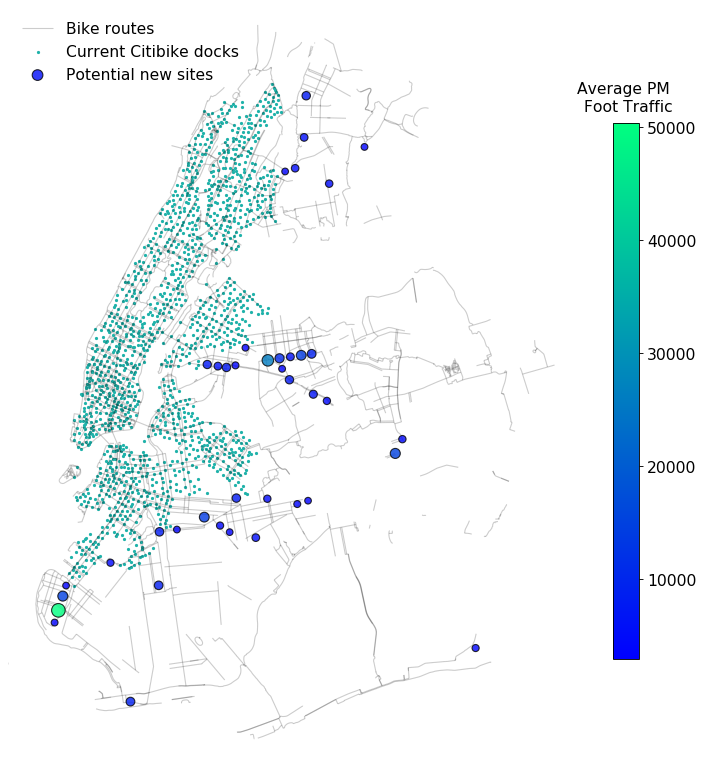

In [44]:
ax = map_nyc_citibike_docks(citibike_spots, alpha=0.2)
plot_top_stations = plot_top_stations.sample(frac=1, random_state=42)

plot_top_stations.to_crs('epsg:4623').plot(column='foot_traffic', 
                                                alpha=0.8, zorder=2, 
                                                markersize=np.sqrt(plot_top_stations['foot_traffic'])/1.5, 
                                                linewidth=1,
                                                edgecolor='k',
                                                cmap=plt.cm.get_cmap('winter'), 
                                                legend=False,
                                                ax=ax)
plt.legend(['Bike routes', 'Current Citibike docks', 'Potential new sites'], loc='upper left',
          frameon=False)

vmin = plot_top_stations.foot_traffic.min()
vmax = plot_top_stations.foot_traffic.max()
sm = plt.cm.ScalarMappable(cmap=plt.cm.get_cmap('winter'), norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
fig = ax.get_figure()
cbr = fig.colorbar(sm, ax=ax, shrink=0.7) 
cbr.ax.set_title('Average PM \n Foot Traffic', pad=10, fontsize=14)
ax.set_xlim([-74.06, -73.7])
p = plt.axis('off')

plt.tight_layout()
plt.savefig('final_map.png')

In [45]:
# Top 10 stations fitting the weekday p.m. commute pattern

df = plot_top_stations[['ref_station_name', 
                  'foot_traffic']].sort_values(by='foot_traffic', ascending=False)
df = df.rename(columns={'ref_station_name': 'Station',
                        'foot_traffic': 'Average PM Foot Traffic'})

from IPython.display import display, HTML
display(HTML(df[:10].to_html(index=False)))

Station,Average PM Foot Traffic
86 ST,50433
JACKSON HTS-ROOSEVELT AV,26090
SUTPHIN BLVD-ARCHER AV-JFK AIRPORT,14989
77 ST,14676
JUNCTION BLVD,13525
CROWN HTS-UTICA AV,13515
82 ST-JACKSON HTS,10398
103 ST-CORONA PLAZA,8772
CONEY ISLAND-STILLWELL AV,8570
NEWKIRK PLAZA,8166
